In [13]:
import pandas as pd
import altair as alt
import geopandas as gpd
import folium
from folium import Choropleth

In [15]:
df_zona_sul = pd.read_excel('BaseViolencia.xlsx')
df_zona_sul.columns

Index(['mes', 'ano', 'mes_ano', 'município', 'regiao', 'bairro', 'cisp',
       'roubo_transeunte', 'roubo_celular', 'roubo_em_coletivo', 'roubo_rua',
       'roubo_veiculo', 'roubo_carga', 'roubo_comercio', 'roubo_residencia',
       'roubo_banco', 'roubo_cx_eletronico', 'roubo_conducao_saque',
       'roubo_apos_saque', 'roubo_bicicleta', 'outros_roubos', 'total_roubos',
       'furto_veiculos', 'furto_transeunte', 'furto_coletivo', 'furto_celular',
       'furto_bicicleta', 'outros_furtos', 'total_furtos'],
      dtype='object')

Aqui colocamos em percentuais para conseguirmos comparar a representatividade dos roubos em cada bairro, vendo seus destaques e especificidades.

In [13]:
# Gráfico ajustado com interatividade (tooltip para cada ponto)
grafico_linha_interativo = alt.Chart(df_sazonalidade).transform_fold(
    ['total_roubos', 'total_furtos'],
    as_=['Tipo de Crime', 'Quantidade']
).mark_line(strokeWidth=3).encode(
    x=alt.X('mes_ano:T', title='Mês/Ano', axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('Quantidade:Q', title='Quantidade de Crimes', scale=alt.Scale(zero=False)),
    color=alt.Color(
        'Tipo de Crime:N',
        title='Tipo de Crime',
        scale=alt.Scale(
            domain=['total_roubos', 'total_furtos'],
            range=['#FF4500', '#1E90FF']  # Laranja para roubos, Azul para furtos
        )
    ),
    tooltip=[
        alt.Tooltip('mes_ano:T', title='Mês/Ano'),
        alt.Tooltip('Tipo de Crime:N', title='Tipo de Crime'),
        alt.Tooltip('Quantidade:Q', title='Quantidade')
    ]
).properties(
    width=700,
    height=400,
    title='Evolução de Roubos e Furtos ao Longo do Tempo (Com Tooltip)'
).configure_title(
    fontSize=16,
    anchor='start'
)

grafico_linha_interativo.show()


alt.Chart(...)

In [11]:
# Ordenando os bairros pelo total de roubos
total_roubos_por_bairro = (
    df_percentuais.groupby("bairro")["quantidade"].sum().reset_index()
    .sort_values(by="quantidade", ascending=False)
)

# Adicionando a ordem no DataFrame original
df_percentuais["bairro"] = pd.Categorical(
    df_percentuais["bairro"],
    categories=total_roubos_por_bairro["bairro"],
    ordered=True
)

# Criando o gráfico de barras segmentadas com cores ajustadas
grafico = alt.Chart(df_percentuais).mark_bar().encode(
    x=alt.X("percentual:Q", stack="normalize", title="Proporção (%)"),
    y=alt.Y("bairro:N", sort="ascending", title="Bairro"),
    color=alt.Color(
        "tipo_roubo:N", 
        title="Tipo de Roubo", 
        scale=alt.Scale(
            domain=[
                "roubo_veiculo", "roubo_transeunte", "roubo_celular", "roubo_bicicleta",
                "roubo_em_coletivo", "roubo_carga", "roubo_residencia", "roubo_comercio",
                "roubo_apos_saque", "roubo_cx_eletronico", "roubo_conducao_saque", 
                "roubo_banco", "outros_roubos", "roubo_rua"
            ],
            range=[
                "#4E79A7",  # roubo_veiculo - Azul Suave
                "#228B22",  # roubo_transeunte - Verde Escuro
                "#E15759",  # roubo_celular - Vermelho
                "#76B7B2",  # roubo_bicicleta - Verde Água
                "#59A14F",  # roubo_em_coletivo - Verde
                "#EDC949",  # roubo_carga - Amarelo
                "#AF7AA1",  # roubo_residencia - Roxo Claro
                "#FF9DA7",  # roubo_comercio - Rosa Claro
                "#9C755F",  # roubo_apos_saque - Marrom Claro
                "#BAB0AB",  # roubo_cx_eletronico - Cinza Claro
                "#D37295",  # roubo_conducao_saque - Rosa Escuro
                "#FABFD2",  # roubo_banco - Rosa Suave
                "#9467BD",  # outros_roubos - Lilás
                "#1F77B4"   # roubo_rua - Azul Claro
            ]
        )
    ),
    order=alt.Order("percentual:Q", sort="ascending"),
    tooltip=["bairro:N", "tipo_roubo:N", "quantidade:Q", "percentual:Q"]
).properties(
    title="Distribuição Percentual dos Tipos de Roubo por Bairro na Zona Sul",
    width=600,
    height=400
).configure_title(
    fontSize=16,
    anchor="start"
)

grafico.show()

C:\Users\mages\AppData\Local\Temp\ipykernel_33072\3517887988.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_percentuais.groupby("bairro")["quantidade"].sum().reset_index()


alt.Chart(...)

In [18]:
# Ajustando o DataFrame para incluir os tipos de furto (sem total_furtos)
df_furtos = df_zona_sul.melt(
    id_vars=["bairro"], 
    value_vars=[
        "furto_veiculos", "furto_transeunte", "furto_coletivo", "furto_celular",
        "furto_bicicleta", "outros_furtos"
    ], 
    var_name="tipo_furto", 
    value_name="quantidade"
)

# Agrupando e calculando percentuais por bairro
df_percentuais_furtos = (
    df_furtos.groupby(["bairro", "tipo_furto"])["quantidade"]
    .sum()
    .reset_index()
)
df_percentuais_furtos["percentual"] = (
    df_percentuais_furtos.groupby("bairro")["quantidade"]
    .transform(lambda x: (x / x.sum()) * 100)
)

# Ordenando os bairros pelo total de furtos usando a coluna total_furtos
total_furtos_por_bairro = (
    df_zona_sul.groupby("bairro")["total_furtos"].sum().reset_index()
    .sort_values(by="total_furtos", ascending=False)
)

# Adicionando a ordem no DataFrame original
df_percentuais_furtos["bairro"] = pd.Categorical(
    df_percentuais_furtos["bairro"],
    categories=total_furtos_por_bairro["bairro"],
    ordered=True
)

# Criando o gráfico de barras segmentadas com cores ajustadas
grafico_furtos = alt.Chart(df_percentuais_furtos).mark_bar().encode(
    x=alt.X("percentual:Q", stack="normalize", title="Proporção (%)"),
    y=alt.Y("bairro:N", sort="ascending", title="Bairro"),
    color=alt.Color(
        "tipo_furto:N", 
        title="Tipo de Furto", 
        scale=alt.Scale(
            domain=[
                "furto_veiculos", "furto_transeunte", "furto_coletivo", "furto_celular",
                "furto_bicicleta", "outros_furtos"
            ],
            range=[
                "#4E79A7",  # furto_veiculos - Azul Suave
                "#228B22",  # furto_transeunte - Verde Escuro
                "#76B7B2",  # furto_coletivo - Verde Água
                "#E15759",  # furto_celular - Vermelho
                "#59A14F",  # furto_bicicleta - Verde Claro
                "#9467BD"   # outros_furtos - Lilás
            ]
        )
    ),
    order=alt.Order("percentual:Q", sort="ascending"),
    tooltip=["bairro:N", "tipo_furto:N", "quantidade:Q", "percentual:Q"]
).properties(
    title="Distribuição Percentual dos Tipos de Furto por Bairro na Zona Sul",
    width=600,
    height=400
).configure_title(
    fontSize=16,
    anchor="start"
)

grafico_furtos.show()

alt.Chart(...)

In [30]:
regiao_zs = pd.read_json('geojs-33-mun.json')
regiao_zs

,type,features
0,FeatureCollection,"{'type': 'Feature', 'properties': {'id': '3300..."
1,FeatureCollection,"{'type': 'Feature', 'properties': {'id': '3300..."
2,FeatureCollection,"{'type': 'Feature', 'properties': {'id': '3300..."
3,FeatureCollection,"{'type': 'Feature', 'properties': {'id': '3300..."
4,FeatureCollection,"{'type': 'Feature', 'properties': {'id': '3300..."
...,...,...
87,FeatureCollection,"{'type': 'Feature', 'properties': {'id': '3306..."
88,FeatureCollection,"{'type': 'Feature', 'properties': {'id': '3306..."
89,FeatureCollection,"{'type': 'Feature', 'properties': {'id': '3306..."
90,FeatureCollection,"{'type': 'Feature', 'properties': {'id': '3306..."


In [19]:
import pandas as pd
import plotly.express as px

# Preparando os dados
crimes = [
    "roubo_transeunte", "roubo_celular", "roubo_em_coletivo", "roubo_rua",
    "roubo_veiculo", "roubo_carga", "roubo_comercio", "roubo_residencia",
    "roubo_banco", "roubo_cx_eletronico", "roubo_conducao_saque",
    "roubo_apos_saque", "roubo_bicicleta",
    "furto_veiculos", "furto_transeunte", "furto_coletivo", "furto_celular",
    "furto_bicicleta"
]

# Agrupando os dados por tipo de crime
df_crimes = df_zona_sul.melt(
    id_vars=["mes", "ano", "mes_ano", "município", "regiao", "bairro", "cisp"], 
    value_vars=crimes, 
    var_name="tipo_crime", 
    value_name="quantidade"
).groupby("tipo_crime")["quantidade"].sum().reset_index()

# Renomeando os crimes para rótulos mais amigáveis
nome_amigavel = {
    "roubo_transeunte": "Roubo de Transeunte",
    "roubo_celular": "Roubo de Celular",
    "roubo_em_coletivo": "Roubo em Coletivo",
    "roubo_rua": "Roubo na Rua",
    "roubo_veiculo": "Roubo de Veículo",
    "roubo_carga": "Roubo de Carga",
    "roubo_comercio": "Roubo no Comércio",
    "roubo_residencia": "Roubo em Residência",
    "roubo_banco": "Roubo em Banco",
    "roubo_cx_eletronico": "Roubo no Caixa Eletrônico",
    "roubo_conducao_saque": "Roubo em Condução Após Saque",
    "roubo_apos_saque": "Roubo Após Saque",
    "roubo_bicicleta": "Roubo de Bicicleta",
    "furto_veiculos": "Furto de Veículos",
    "furto_transeunte": "Furto de Transeunte",
    "furto_coletivo": "Furto em Coletivo",
    "furto_celular": "Furto de Celular",
    "furto_bicicleta": "Furto de Bicicleta",
}
df_crimes["tipo_crime"] = df_crimes["tipo_crime"].map(nome_amigavel)

# Criando o gráfico de Tree Map com melhorias
fig = px.treemap(
    df_crimes,
    path=["tipo_crime"],
    values="quantidade",
    color="quantidade",
    color_continuous_scale=px.colors.sequential.YlOrRd,  # Ajustando a escala correta
    title="Distribuição Proporcional dos Tipos de Crime na Zona Sul"
)

# Ajustes na aparência do gráfico
fig.update_traces(
    textinfo="label+value",  # Mostra os valores dentro dos blocos
    textfont_size=14,        # Aumenta o tamanho da fonte
    texttemplate="%{label}<br>%{value} ocorrências"
)
fig.update_layout(
    margin=dict(t=50, l=25, r=25, b=25),
    title_font_size=18,
    coloraxis_colorbar=dict(
        title="Ocorrências",
        thickness=15
    )
)

# Exibindo o gráfico
fig.show()

In [16]:
import pandas as pd
import plotly.express as px

# Calculando o total de crimes por mês
df_meses = df_zona_sul.copy()
df_meses["total_crimes"] = df_meses[[
    "roubo_transeunte", "roubo_celular", "roubo_em_coletivo", "roubo_rua",
    "roubo_veiculo", "roubo_carga", "roubo_comercio", "roubo_residencia",
    "roubo_banco", "roubo_cx_eletronico", "roubo_conducao_saque",
    "roubo_apos_saque", "roubo_bicicleta", "outros_roubos",
    "furto_veiculos", "furto_transeunte", "furto_coletivo", "furto_celular",
    "furto_bicicleta", "outros_furtos"
]].sum(axis=1)

# Agrupando por mês
df_meses_agrupados = df_meses.groupby("mes")["total_crimes"].sum().reset_index()

# Identificando o mês com mais crimes
mes_maximo = df_meses_agrupados.loc[df_meses_agrupados["total_crimes"].idxmax(), "mes"]

# Adicionando uma coluna para destacar o mês com mais ocorrências
df_meses_agrupados["cor"] = df_meses_agrupados["mes"].apply(
    lambda x: "red" if x == mes_maximo else "white"
)

# Criando o gráfico
fig = px.bar(
    df_meses_agrupados,
    x="mes",
    y="total_crimes",
    color="cor",  # Usando a coluna de cores para personalizar
    color_discrete_map={"red": "red", "white": "white"},
    labels={"mes": "Mês", "total_crimes": "Total de Crimes"},
    title="Total de Ocorrências por Mês na Zona Sul"
)

# Ajustando o layout
fig.update_traces(
    marker=dict(line=dict(color="black", width=1.5))  # Contorno das barras
)
fig.update_layout(
    xaxis=dict(
        tickmode="array",
        tickvals=list(range(1, 13)),
        ticktext=["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez"]
    ),
    title_font_size=18
)

# Exibindo o gráfico
fig.show()

In [4]:
df_mapa = pd.read_csv('Limite_de_Bairros.csv')
df_mapa

,objectid,área,nome,regiao_adm,area_plane,codbairro,codra,codbnum,link,rp,cod_rp,codbairro_long,st_areashape,st_perimetershape
0,325,1.705685e+06,Paquetá,PAQUETA,1,13,21,13,Paqueta&area=013 ...,Centro,1.1,13,1.705689e+06,24841.459984
1,326,4.056403e+06,Freguesia (Ilha),ILHA DO GOVERNADOR,3,98,20,98,Freguesia (Ilha) &area=98 ...,Ilha do Governador,3.7,98,4.056414e+06,18303.621385
2,327,9.780465e+05,Bancários,ILHA DO GOVERNADOR,3,97,20,97,Bancários &area=97 ...,Ilha do Governador,3.7,97,9.780492e+05,7758.791895
3,328,1.895742e+07,Galeão,ILHA DO GOVERNADOR,3,104,20,104,Galeão &area=104 ...,Ilha do Governador,3.7,104,1.895747e+07,21510.088396
4,329,1.672546e+06,Tauá,ILHA DO GOVERNADOR,3,101,20,101,Tauá &area=101 ...,Ilha do Governador,3.7,101,1.672550e+06,8246.120720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,512,2.534304e+06,Gericinó,BANGU,5,160,17,160,Gericinó &area=160,Bangu,5.1,160,2.534311e+06,8828.555709
161,513,3.273271e+05,Jabour,BANGU,5,163,17,163,Jabour &area=163,Bangu,5.1,163,3.273280e+05,2235.748407
162,890,1.473737e+06,Vila Kennedy,BANGU,5,162,17,162,Vila Kennedy &area=162,Bangu,5.1,162,1.473741e+06,6789.609579
163,894,7.714616e+06,Ilha de Guaratiba,GUARATIBA,5,164,26,164,Ilha de Guaratiba &area=164,Guaratiba,5.4,164,7.714637e+06,13955.136856


In [5]:
filtro_zs = df_mapa[df_mapa['rp'] == 'Zona Sul']
filtro_zs.to_csv('Limites_filtrados.csv')
filtro_zs

,objectid,área,nome,regiao_adm,area_plane,codbairro,codra,codbnum,link,rp,cod_rp,codbairro_long,st_areashape,st_perimetershape
111,438,1.140065e+06,Glória,BOTAFOGO,2,16,4,16,Glória &area=16 ...,Zona Sul,2.1,16,1.140069e+06,7225.248107
120,447,6.810267e+05,Catete,BOTAFOGO,2,18,4,18,Catete &area=18 ...,Zona Sul,2.1,18,6.810285e+05,4260.147747
121,448,1.646254e+06,Flamengo,BOTAFOGO,2,15,4,15,Flamengo &area=15 ...,Zona Sul,2.1,15,1.646258e+06,6665.349163
122,449,2.493507e+06,Laranjeiras,BOTAFOGO,2,17,4,17,Laranjeiras &area=17 ...,Zona Sul,2.1,17,2.493514e+06,10537.128736
126,453,8.925401e+05,Cosme Velho,BOTAFOGO,2,19,4,19,Cosme Velho &area=19 ...,Zona Sul,2.1,19,8.925425e+05,7889.681452
128,455,4.798956e+06,Botafogo,BOTAFOGO,2,20,4,20,Botafogo &area=20 ...,Zona Sul,2.1,20,4.798969e+06,12136.391939
129,456,2.319002e+06,Urca,BOTAFOGO,2,22,4,22,Urca &area=22 ...,Zona Sul,2.1,22,2.319008e+06,14138.523910
135,462,1.054475e+06,Humaitá,BOTAFOGO,2,21,4,21,Humaitá &area=21 ...,Zona Sul,2.1,21,1.054478e+06,7100.855819
137,464,2.689204e+06,Jardim Botânico,LAGOA,2,28,6,28,Jardim Botânico &area=28 ...,Zona Sul,2.1,28,2.689211e+06,12263.131623
139,466,4.100850e+06,Copacabana,COPACABANA,2,24,5,24,Copacabana &area=24 ...,Zona Sul,2.1,24,4.100861e+06,12803.516209


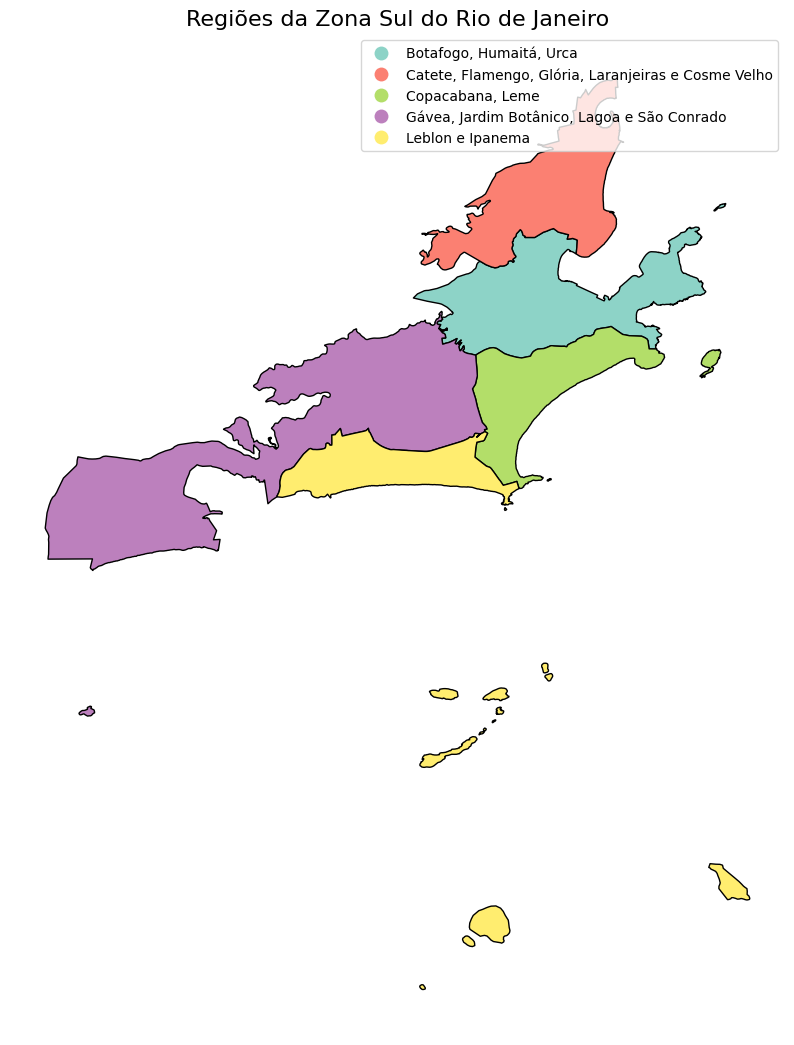

In [9]:
# Carregar o arquivo GeoJSON
geojson_path = "Limite_de_Bairros.geojson"  # Substitua pelo caminho correto
gdf = gpd.read_file(geojson_path)

# Definir os grupos de bairros para cada região
bairros = {
    "Botafogo, Humaitá, Urca": ["Botafogo", "Humaitá", "Urca"],
    "Catete, Flamengo, Glória, Laranjeiras e Cosme Velho": ["Catete", "Flamengo", "Glória", "Laranjeiras", "Cosme Velho"],
    "Copacabana, Leme": ["Copacabana", "Leme"],
    "Gávea, Jardim Botânico, Lagoa e São Conrado": ["Gávea", "Jardim Botânico", "Lagoa", "São Conrado"],
    "Leblon e Ipanema": ["Leblon", "Ipanema"]
}

# Filtrar apenas os bairros da Zona Sul
# Criar uma nova coluna 'regiao' com base nos grupos definidos
gdf["bairro"] = None

for bairro, bairros in bairros.items():
    gdf.loc[gdf["nome"].isin(bairros), "bairro"] = bairro

# Filtrar apenas os bairros que pertencem às regiões definidas
gdf_zona_sul = gdf[gdf["bairro"].notnull()]

# Dissolver as geometrias por região (agrupando os bairros por região)
gdf_regioes = gdf_zona_sul.dissolve(by="bairro", as_index=False)

# Plotar o mapa para visualizar as regiões
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 40))
gdf_regioes.plot(ax=ax, column="bairro", legend=True, edgecolor="black", cmap="Set3")
plt.title("Regiões da Zona Sul do Rio de Janeiro", fontsize=16)
plt.axis("off")
plt.show()

# Salvar o GeoJSON com as regiões agrupadas
gdf_regioes.to_file("Regioes_Zona_Sul.geojson", driver="GeoJSON")

In [10]:
# Carregar o arquivo GeoJSON
geojson_path = "Regioes_Zona_Sul.geojson"
gdf = gpd.read_file(geojson_path)

# Salvar como CSV
csv_path = "Regioes_Zona_Sul.csv"
gdf.to_csv(csv_path, index=False)

print(f"GeoJSON convertido para CSV e salvo em: {csv_path}")

GeoJSON convertido para CSV e salvo em: Regioes_Zona_Sul.csv


In [11]:
df_zona_geo = pd.read_csv('Regioes_Zona_Sul.csv')
df_zona_geo

,bairro,objectid,área,nome,regiao_adm,area_plane,codbairro,codra,codbnum,link,rp,cod_rp,codbairro_long,st_areashape,st_perimetershape,geometry
0,"Botafogo, Humaitá, Urca",455,4.798956e+06,Botafogo,BOTAFOGO,2,20,4,20,Botafogo &area=20 ...,Zona Sul,2.1,20,4.798969e+06,12136.391939,MULTIPOLYGON (((-43.19901357398269 -22.9624069...
1,"Catete, Flamengo, Glória, Laranjeiras e Cosme ...",438,1.140065e+06,Glória,BOTAFOGO,2,16,4,16,Glória &area=16 ...,Zona Sul,2.1,16,1.140069e+06,7225.248107,POLYGON ((-43.19965558631965 -22.9433368098720...
2,"Copacabana, Leme",466,4.100850e+06,Copacabana,COPACABANA,2,24,5,24,Copacabana &area=24 ...,Zona Sul,2.1,24,4.100861e+06,12803.516209,MULTIPOLYGON (((-43.18250496691897 -22.9864852...
3,"Gávea, Jardim Botânico, Lagoa e São Conrado",464,2.689204e+06,Jardim Botânico,LAGOA,2,28,6,28,Jardim Botânico &area=28 ...,Zona Sul,2.1,28,2.689211e+06,12263.131623,MULTIPOLYGON (((-43.27535779568179 -23.0297350...
4,Leblon e Ipanema,472,2.153096e+06,Leblon,LAGOA,2,26,6,26,Leblon &area=26 ...,Zona Sul,2.1,26,2.153102e+06,7188.672220,MULTIPOLYGON (((-43.20847617797942 -23.0821021...


In [17]:
# Carregar o GeoJSON
geojson_path = "Regioes_Zona_Sul.geojson"  # Substitua pelo caminho correto
gdf_regioes = gpd.read_file(geojson_path)

# Criar a coluna 'total_crimes' no df_zona_sul somando total_roubos e total_furtos
df_zona_sul["total_crimes"] = df_zona_sul["total_roubos"] + df_zona_sul["total_furtos"]

# Agrupar os dados por região
df_crimes_grouped = df_zona_sul.groupby("bairro")["total_crimes"].sum().reset_index()

rename_map = {
    "Catete, Flamengo, Laranjeiras, Glória, Cosme Velho": "Catete, Flamengo, Glória, Laranjeiras e Cosme Velho",
    "Gávea, Jardim Botânico, Lagoa, São Conrado": "Gávea, Jardim Botânico, Lagoa e São Conrado",
    "Leblon, Ipanema": "Leblon e Ipanema",
    "Copacabana, Leme": "Copacabana, Leme",
    "Botafogo, Urca, Humaitá": "Botafogo, Humaitá, Urca"
}

# Renomear os bairros no DataFrame de crimes
df_crimes_grouped["bairro"] = df_crimes_grouped["bairro"].replace(rename_map)

cores_fixas = {
    99404: "#FEB24C",  # # Laranja
    101300: "#FF7F32",  # Laranja mais forte
    110214: "#FD7463",  # Vermelho mais claro
    116050: "#FC4E2A",   # Vermelho
    42373: "#FFFFB2"  # Amarelo claro
}

# Mapear as cores para cada valor no DataFrame
df_crimes_grouped["cor"] = df_crimes_grouped["total_crimes"].map(cores_fixas)

# Unir os dados do GeoJSON com os dados agrupados
gdf_regioes = gdf_regioes.merge(df_crimes_grouped, on="bairro", how="left")

# Converter o GeoDataFrame para GeoJSON
geojson_data = gdf_regioes.to_json()

# Criar o mapa com Folium
mapa = folium.Map(location=[-22.971, -43.182], zoom_start=13)

# Adicionar polígonos ao mapa com as cores fixas
for _, row in gdf_regioes.iterrows():
    folium.GeoJson(
        row["geometry"],
        style_function=lambda feature, color=row["cor"]: {
            "fillColor": color,
            "color": "black",
            "weight": 1,
            "fillOpacity": 0.7
        }
    ).add_to(mapa)

# Exibir o mapa
mapa.save("mapa_criminalidade_categorias.html")
mapa

In [12]:
# Verifique os dados no GeoJSON após a união
print("GeoJSON com dados de crimes:")
print(gdf_regioes[["bairro", "total_crimes"]])

# Verifique os dados no DataFrame de crimes agrupados
print("DataFrame de crimes agrupados:")
print(df_crimes_grouped)

GeoJSON com dados de crimes:


KeyError: "['total_crimes'] not in index"